# Place Downloanded/Captured images in the images folders

In [1]:
import os
img_dir=os.path.join(os.getcwd(),'images')


In [2]:
# base imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# preprocessing imports
import cv2
from glob import glob
from PIL import Image as imgop
import imageio
# model imports
import tensorflow as tf
tf.__version__
import segmentation_models as sm
sm.set_framework('tf.keras')

# fixed parameter
IMG_DIM=256

# preprocess data
def get_img(_path,expand=True):
    data=imgop.open(_path)
    data=data.resize((IMG_DIM,IMG_DIM))
    data=np.array(data)
    data=data.astype('float32')/255.0
    if expand: # for prediction (256,256,3) -> (1,256,256,3)
        data=np.expand_dims(data,axis=0)
    return data

def get_pred(model,img,_path):
    _ppath=str(_path).replace('images','preds')
    pred=model.predict([img])
    pred =np.squeeze(pred)*255.0
    pred=pred.astype('uint8')
    imageio.imsave(_ppath,pred)
    # save predictions (api problem)
    pred=cv2.imread(_ppath,0)
    pred= cv2.resize(pred,(IMG_DIM,IMG_DIM), interpolation = cv2.INTER_AREA)
    # Otsu's thresholding after Gaussian filtering
    blur = cv2.GaussianBlur(pred,(5,5),0)
    _,pred = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return pred


def get_overlay(pred,img):
    img=np.squeeze(img)
    overlay=img*0.2
    xs,ys=np.nonzero(pred)
    for x,y in zip(xs,ys):
        overlay[x,y,:]=img[x,y,:]
    
    return overlay


# plotting data
def plot_data_3(x,y,z):
    fig, (ax1,ax2,ax3) = plt.subplots(1, 3,figsize=(20,20))
    ax1.imshow(x)
    ax2.imshow(y)
    ax3.imshow(z)
    plt.show()


Segmentation Models: using `tf.keras` framework.


In [3]:
# models (only load stable models)
import time
st=time.time()
model= sm.Unet('efficientnetb7', input_shape=(256,256,3), encoder_weights=None,classes=1)
model.load_weights(os.path.join(os.getcwd(),'weights','model1.h5'))
print(time.time()-st)


10.868807315826416


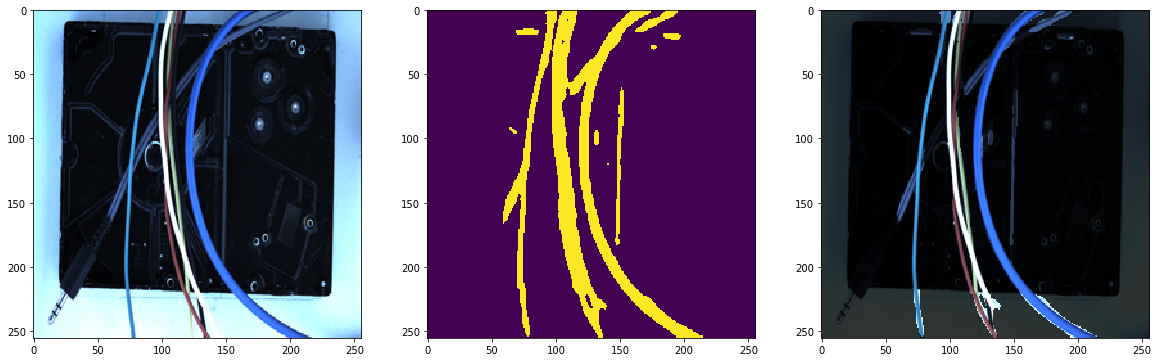

In [4]:
img_paths=glob(os.path.join(img_dir,'*.*'))
for _path in img_paths:
    # image ([])
    img=get_img(_path)    
    # predictions ([])
    pred=get_pred(model,img,_path)
    # overlays ([])
    overlay=get_overlay(pred,img)
    plot_data_3(np.squeeze(img),np.squeeze(pred),np.squeeze(overlay))
